In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path="/content/drive/MyDrive/Artificial_Intelligence_Course_NTUT/hw5/"
import pickle

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import vit_b_16
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# use simple augumentation, should generalize better
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 34.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Files already downloaded and verified
Files already downloaded and verified


<ipython-input-4-3ce5715b0e90>:46: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/14


Training:   0%|          | 0/391 [00:00<?, ?it/s]<ipython-input-4-3ce5715b0e90>:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision


Train Loss: 0.7494, Test Loss: 0.6868, Accuracy: 92.07%
Epoch 2/14


Train Loss: 0.6469, Test Loss: 0.6525, Accuracy: 93.44%
Epoch 3/14


Train Loss: 0.6131, Test Loss: 0.6551, Accuracy: 93.38%
Epoch 4/14


Train Loss: 0.5849, Test Loss: 0.6154, Accuracy: 94.90%
Epoch 5/14


Train Loss: 0.5629, Test Loss: 0.6135, Accuracy: 95.13%
Epoch 6/14


Train Loss: 0.5273, Test Loss: 0.5945, Accuracy: 96.30%
Epoch 7/14


Train Loss: 0.5135, Test Loss: 0.5837, Accuracy: 97.03%
Epoch 8/14


Train Loss: 0.5063, Test Loss: 0.5725, Accuracy: 97.49%
Epoch 9/14


Train Loss: 0.5035, Test Loss: 0.5698, Accuracy: 97.72%
Epoch 10/14


Train Loss: 0.5028, Test Loss: 0.5673, Accuracy: 97.78%
Epoch 11/14


Train Loss: 0.5020, Test Loss: 0.5673, Accuracy: 97.78%
Epoch 12/14


Train Loss: 0.5018, Test Loss: 0.5673, Accuracy: 97.79%
Epoch 13/14


Train Loss: 0.5017, Test Loss: 0.5696, Accuracy: 97.76%
Epoch 14/14


Train Loss: 0.5020, Test Loss: 0.5704, Accuracy: 97.79%


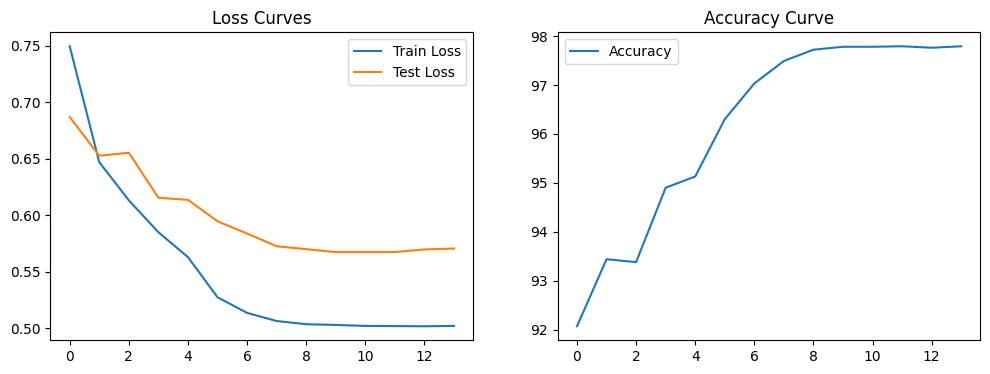

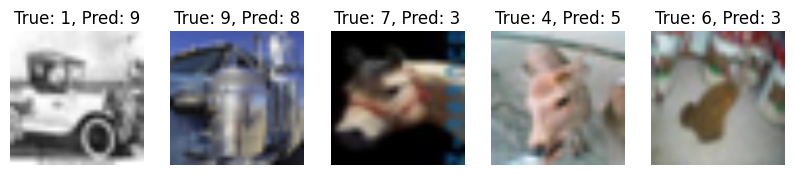

In [ ]:
# model setup for 10 classes
model = vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # Learning rate scheduler

scaler = GradScaler()

# train & eval loop
num_epochs = 14
train_losses = []
test_losses = []
accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    print(f"Epoch {epoch+1}/{num_epochs}")

    # train
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # eval
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    accuracy.append(100 * correct / total)
    scheduler.step()  # over time it may be worth to adjust the learning rate -> do it

    print(f"Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy[-1]:.2f}%")

    # store model for cases of fail or running out of colab resources
    with open(file_path + 'model.pkl', 'wb') as f:
        pickle.dump(model, f)

# visu
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.show()

misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Finding Misclassified", leave=False):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

plt.figure(figsize=(10, 5))
for i in range(min(5, len(misclassified))):
    img, true_label, pred_label = misclassified[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5  # De-normalize
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
plt.show()

In [7]:
import pickle
import torch
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# final eval
with open(file_path + 'model_final.pkl', 'rb') as f:
    model = pickle.load(f)
model.eval()

num_classes = 10
classes = [str(i) for i in range(num_classes)]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

true_labels = []
predictions = []
probabilities = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())
        probabilities.extend(probs.cpu().numpy())


Evaluating: 100%|██████████| 79/79 [02:04<00:00,  1.58s/it]


In [12]:
from sklearn.metrics import classification_report
import numpy as np
# pracision, recall, f1

report = classification_report(true_labels, predictions, target_names=classes, output_dict=True)
precision = [report[str(i)]['precision'] for i in range(num_classes)]
recall = [report[str(i)]['recall'] for i in range(num_classes)]
f1_score = [report[str(i)]['f1-score'] for i in range(num_classes)]

avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")


Average Precision: 0.9780
Average Recall: 0.9779
Average F1-Score: 0.9779


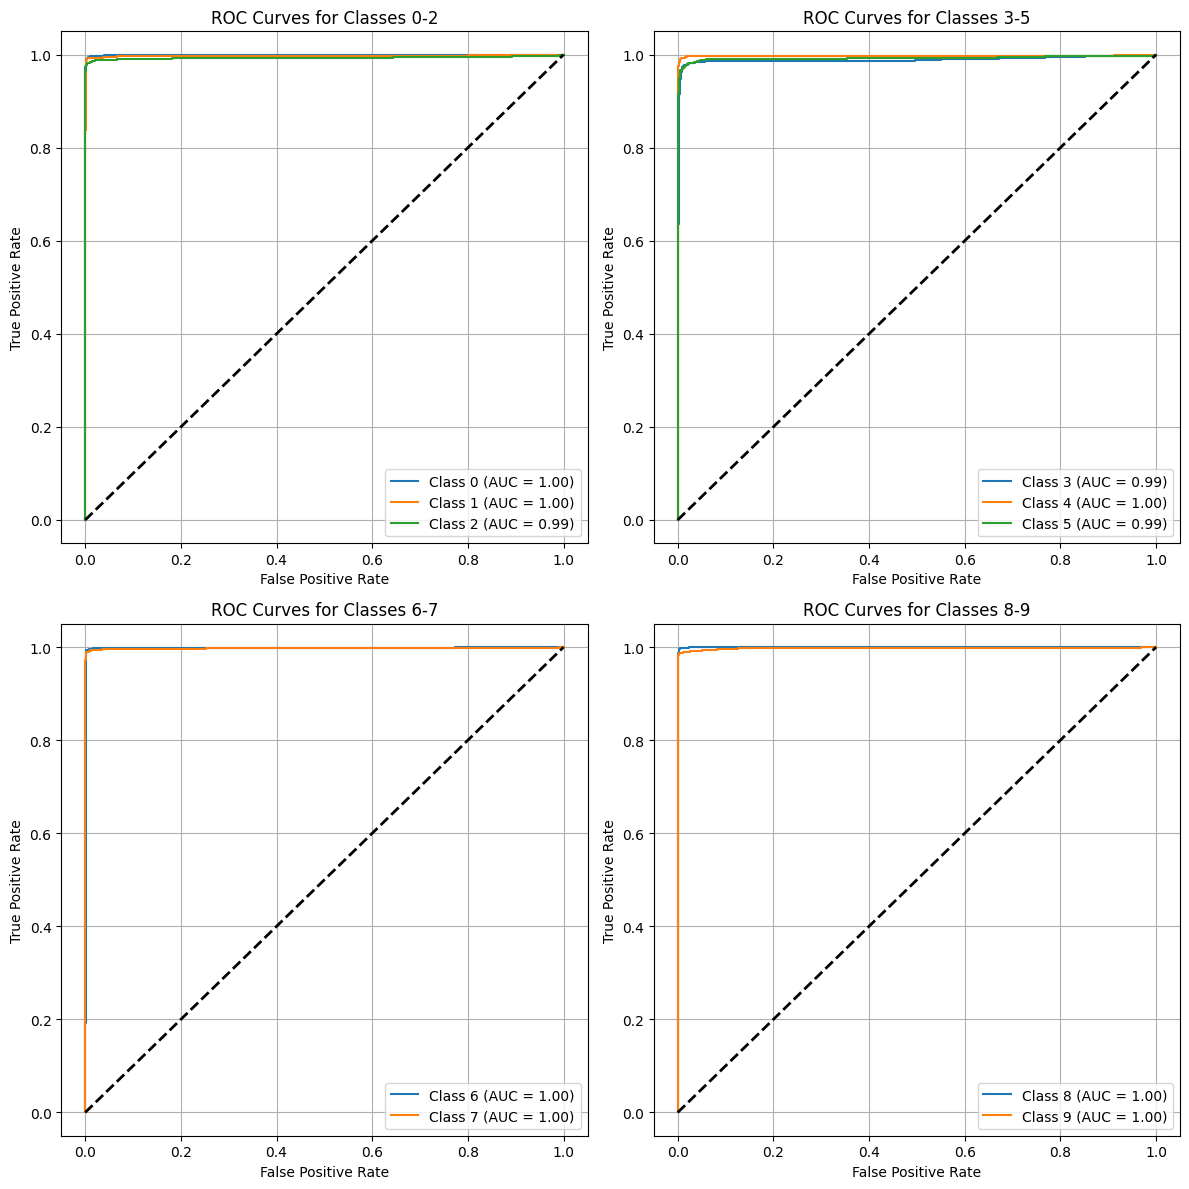

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.flatten()
num_classes = 10

# 4 graphs showing 10 curves
for i in range(3):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], np.array(probabilities)[:, i])
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
axs[0].plot([0, 1], [0, 1], 'k--', lw=2)
axs[0].set_title('ROC Curves for Classes 0-2')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend(loc='lower right')
axs[0].grid()
for i in range(3, 6):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], np.array(probabilities)[:, i])
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
axs[1].plot([0, 1], [0, 1], 'k--', lw=2)
axs[1].set_title('ROC Curves for Classes 3-5')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend(loc='lower right')
axs[1].grid()
for i in range(6, 8):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], np.array(probabilities)[:, i])
    roc_auc = auc(fpr, tpr)
    axs[2].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
axs[2].plot([0, 1], [0, 1], 'k--', lw=2)
axs[2].set_title('ROC Curves for Classes 6-7')
axs[2].set_xlabel('False Positive Rate')
axs[2].set_ylabel('True Positive Rate')
axs[2].legend(loc='lower right')
axs[2].grid()
for i in range(8, 10):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], np.array(probabilities)[:, i])
    roc_auc = auc(fpr, tpr)
    axs[3].plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
axs[3].plot([0, 1], [0, 1], 'k--', lw=2)
axs[3].set_title('ROC Curves for Classes 8-9')
axs[3].set_xlabel('False Positive Rate')
axs[3].set_ylabel('True Positive Rate')
axs[3].legend(loc='lower right')
axs[3].grid()
plt.tight_layout()
plt.show()
fig.savefig(file_path + "roc.png")


In [14]:
from sklearn.metrics import roc_auc_score
import numpy as np
# average auc
roc_auc = {}
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(true_binarized[:, i], np.array(probabilities)[:, i])
    roc_auc[i] = auc(fpr, tpr)

avg_auc = np.mean(list(roc_auc.values()))
print(f"Average AUC: {avg_auc:.4f}")


Average AUC: 0.9956
